In [127]:
 import numpy as np
import pandas as pd

import torch
import torchvision
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, utils
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from matplotlib import pyplot as plt
%matplotlib inline
from scipy.stats import entropy

In [128]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [129]:
path="/content/drive/MyDrive/Research/alternate_minimisation/type4_data/"

In [130]:
class MosaicDataset1(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, mosaic_list, mosaic_label,fore_idx):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.mosaic = mosaic_list
    self.label = mosaic_label
    self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.label)

  def __getitem__(self, idx):
    return self.mosaic[idx] , self.label[idx] , self.fore_idx[idx]

In [131]:
class SyntheticDataset(Dataset):
  """MosaicDataset dataset."""

  def __init__(self, x, y):
    """
      Args:
        csv_file (string): Path to the csv file with annotations.
        root_dir (string): Directory with all the images.
        transform (callable, optional): Optional transform to be applied
            on a sample.
    """
    self.x = x
    self.y = y
    #self.fore_idx = fore_idx
    
  def __len__(self):
    return len(self.y)

  def __getitem__(self, idx):
    return self.x[idx] , self.y[idx] #, self.fore_idx[idx]

In [132]:
train_data = np.load(path+"train_type4_data.npy",allow_pickle=True)
test_data = np.load(path+"test_type4_data.npy",allow_pickle=True)
data = np.load(path+"type_4_data.npy",allow_pickle=True)

In [133]:
train_mosaic_list_of_images = train_data[0]["mosaic_list"]
train_mosaic_label = train_data[0]["mosaic_label"]
train_fore_idx = train_data[0]["fore_idx"]


test_mosaic_list_of_images = test_data[0]["mosaic_list"]
test_mosaic_label = test_data[0]["mosaic_label"]
test_fore_idx = test_data[0]["fore_idx"]
X = data[0]["X"]
Y = data[0]["Y"]

In [134]:
batch = 250
tr_msd = MosaicDataset1(train_mosaic_list_of_images, train_mosaic_label, train_fore_idx)
train_loader = DataLoader( tr_msd,batch_size= batch ,shuffle=True)

In [135]:
batch = 250
tst_msd = MosaicDataset1(test_mosaic_list_of_images, test_mosaic_label, test_fore_idx)
test_loader = DataLoader( tst_msd,batch_size= batch ,shuffle=True)

In [136]:
dset = SyntheticDataset(X,Y)
dtloader = DataLoader(dset,batch_size =batch,shuffle=True )

**Focus Net**

In [137]:
class Module1(nn.Module):
  def __init__(self):
    super(Module1, self).__init__()
    self.fc1 = nn.Linear(2, 100)
    self.fc2 = nn.Linear(100, 1)

  def forward(self, z):
    x = torch.zeros([batch,9],dtype=torch.float64)
    y = torch.zeros([batch,2], dtype=torch.float64)
    x,y = x.to("cuda"),y.to("cuda")
    for i in range(9):
      x[:,i] = self.helper(z[:,i])[:,0]
    
    log_x = F.log_softmax(x,dim=1)  
    x = F.softmax(x,dim=1)   # alphas
    

    for i in range(9):            
      x1 = x[:,i]          
      y = y + torch.mul(x1[:,None],z[:,i])
    return y , x , log_x
  
  def helper(self,x):
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x
      


**Classification Net**

In [138]:
 class Module2(nn.Module):
  def __init__(self):
    super(Module2, self).__init__()
    self.fc1 = nn.Linear(2, 100)
    self.fc2 = nn.Linear(100, 3)

  def forward(self,y):  
    y = F.relu(self.fc1(y))
    y = self.fc2(y)
    return y


In [139]:
criterion = nn.CrossEntropyLoss()
def my_cross_entropy(x, y,alpha,log_alpha,k):
    # log_prob = -1.0 * F.log_softmax(x, 1)
    # loss = log_prob.gather(1, y.unsqueeze(1))
    # loss = loss.mean()
    loss = criterion(x,y)
    
    #alpha = torch.clamp(alpha,min=1e-10)     
    
    b = -1.0* alpha * log_alpha
    b =  torch.mean(torch.sum(b,dim=1))
    closs = loss
    entropy = b 
    loss = (1-k)*loss + ((k)*b)
    return loss,closs,entropy

In [140]:
def calculate_attn_loss(dataloader,what,where,criter,k):
  what.eval()
  where.eval()
  r_loss = 0
  cc_loss = 0
  cc_entropy = 0
  alphas = []
  lbls = []
  pred = []
  fidices = []
  with torch.no_grad():
    for i, data in enumerate(dataloader, 0):
      inputs, labels,fidx = data
      lbls.append(labels)
      fidices.append(fidx)
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"),labels.to("cuda")
      avg,alpha,log_alpha = where(inputs)
      outputs = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      pred.append(predicted.cpu().numpy())
      alphas.append(alpha.cpu().numpy())

      #ent = np.sum(entropy(alpha.cpu().detach().numpy(), base=2, axis=1))/batch
      # mx,_ = torch.max(alpha,1)
      # entropy = np.mean(-np.log2(mx.cpu().detach().numpy()))
      # print("entropy of batch", entropy)

      #loss = (1-k)*criter(outputs, labels) + k*ent
      loss,closs,entropy = my_cross_entropy(outputs,labels,alpha,log_alpha,k)
      r_loss += loss.item()
      cc_loss += closs.item()
      cc_entropy += entropy.item()

  alphas = np.concatenate(alphas,axis=0)
  pred = np.concatenate(pred,axis=0)
  lbls = np.concatenate(lbls,axis=0)
  fidices = np.concatenate(fidices,axis=0)
  #print(alphas.shape,pred.shape,lbls.shape,fidices.shape) 
  analysis = analyse_data(alphas,lbls,pred,fidices)
  return r_loss/i,cc_loss/i,cc_entropy/i,analysis

In [141]:
def analyse_data(alphas,lbls,predicted,f_idx):
    '''
       analysis data is created here
    '''
    batch = len(predicted)
    amth,alth,ftpt,ffpt,ftpf,ffpf = 0,0,0,0,0,0
    for j in range (batch):
      focus = np.argmax(alphas[j])
      if(alphas[j][focus] >= 0.5):
        amth +=1
      else:
        alth +=1
      if(focus == f_idx[j] and predicted[j] == lbls[j]):
        ftpt += 1
      elif(focus != f_idx[j] and predicted[j] == lbls[j]):
        ffpt +=1
      elif(focus == f_idx[j] and predicted[j] != lbls[j]):
        ftpf +=1
      elif(focus != f_idx[j] and predicted[j] != lbls[j]):
        ffpf +=1
    #print(sum(predicted==lbls),ftpt+ffpt)
    return [ftpt,ffpt,ftpf,ffpf,amth,alth]

In [142]:
number_runs = 10
full_analysis =[]
FTPT_analysis = pd.DataFrame(columns = ["FTPT","FFPT", "FTPF","FFPF"])
k = 0.001

every_what_epoch = 10

for n in range(number_runs):
  print("--"*40)
  
  # instantiate focus and classification Model
  torch.manual_seed(n)
  where = Module1().double()
  torch.manual_seed(n)
  what = Module2().double()

  where = where.to("cuda")
  what = what.to("cuda")



  # instantiate optimizer
  optimizer_where = optim.Adam(where.parameters(),lr =0.001)
  optimizer_what = optim.Adam(what.parameters(), lr=0.001)
  #criterion = nn.CrossEntropyLoss()
  acti = []
  analysis_data = []
  loss_curi = []
  epochs = 1000


  # calculate zeroth epoch loss and FTPT values
  running_loss ,_,_,anlys_data= calculate_attn_loss(train_loader,what,where,criterion,k)
  loss_curi.append(running_loss)
  analysis_data.append(anlys_data)

  print('epoch: [%d ] loss: %.3f' %(0,running_loss)) 

  # training starts 
  for epoch in range(epochs): # loop over the dataset multiple times
    ep_lossi = []
    running_loss = 0.0
    what.train()
    where.train()
    if ((epoch) % (every_what_epoch*2) ) <= every_what_epoch-1 :
      print(epoch+1,"updating what_net, where_net is freezed")
      print("--"*40)
    elif ((epoch) % (every_what_epoch*2)) > every_what_epoch-1 :
      print(epoch+1,"updating where_net, what_net is freezed")
      print("--"*40)
    for i, data in enumerate(train_loader, 0):
      # get the inputs
      inputs, labels,_ = data
      inputs = inputs.double()
      inputs, labels = inputs.to("cuda"),labels.to("cuda")

      # zero the parameter gradients
      optimizer_where.zero_grad()
      optimizer_what.zero_grad()
      
      # forward + backward + optimize
      avg, alpha,log_alpha = where(inputs)
      outputs = what(avg)

      my_loss,_,_ = my_cross_entropy(outputs,labels,alpha,log_alpha,k)

      # print statistics
      running_loss += my_loss.item()
      my_loss.backward()

      if ((epoch) % (every_what_epoch*2) ) <= every_what_epoch-1 :
        optimizer_what.step()
      elif ( (epoch) % (every_what_epoch*2)) > every_what_epoch-1 :
        optimizer_where.step()
        
      # optimizer_where.step()
      # optimizer_what.step()
    #break
    running_loss,ccloss,ccentropy,anls_data = calculate_attn_loss(train_loader,what,where,criterion,k)
    analysis_data.append(anls_data)
    print('epoch: [%d] loss: %.3f celoss: %.3f entropy: %.3f' %(epoch + 1,running_loss,ccloss,ccentropy)) 
    loss_curi.append(running_loss)   #loss per epoch
    if running_loss<=0.005:
      break
  print('Finished Training run ' +str(n))
  #break
  analysis_data = np.array(analysis_data)
  FTPT_analysis.loc[n] = analysis_data[-1,:4]/30
  full_analysis.append((epoch, analysis_data))
  correct = 0
  total = 0
  with torch.no_grad():
    for data in train_loader:
      images, labels,_ = data
      images = images.double()
      images, labels = images.to("cuda"), labels.to("cuda")
      avg, alpha,log_alpha = where(images)
      outputs  = what(avg)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()

  print('Accuracy of the network on the 3000 train images: %d %%' % (  100 * correct / total))
    

Streaming output truncated to the last 5000 lines.
--------------------------------------------------------------------------------
epoch: [15] loss: 1.190 celoss: 1.189 entropy: 2.377
16 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
epoch: [16] loss: 1.189 celoss: 1.188 entropy: 2.372
17 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
epoch: [17] loss: 1.189 celoss: 1.188 entropy: 2.358
18 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
epoch: [18] loss: 1.188 celoss: 1.187 entropy: 2.346
19 updating where_net, what_net is freezed
--------------------------------------------------------------------------------
epoch: [19] loss: 1.188 celoss: 1.187 entropy: 2.339
20 updating where_net, what_net is freezed
----------------------------------------------------------------

In [143]:
a,b= full_analysis[0]
print(a)

999


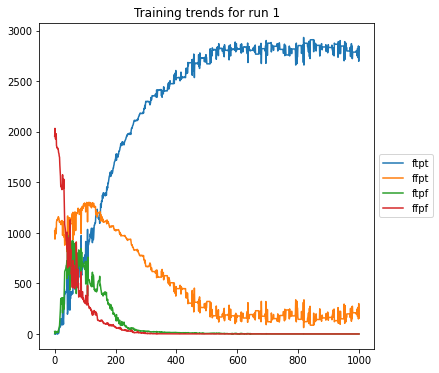

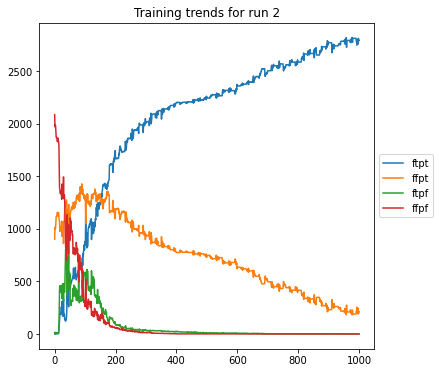

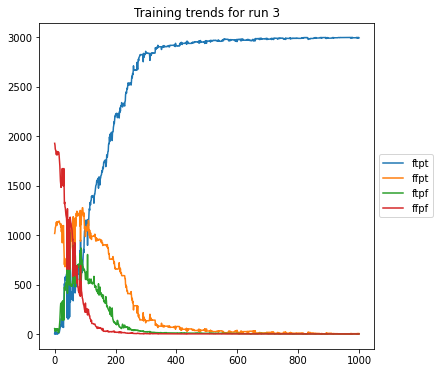

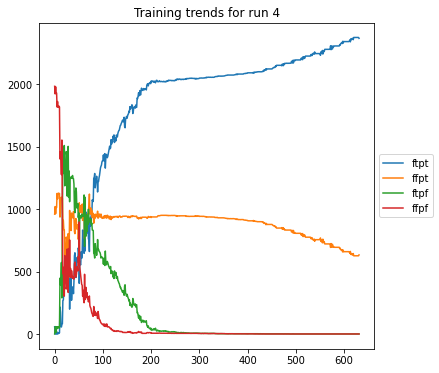

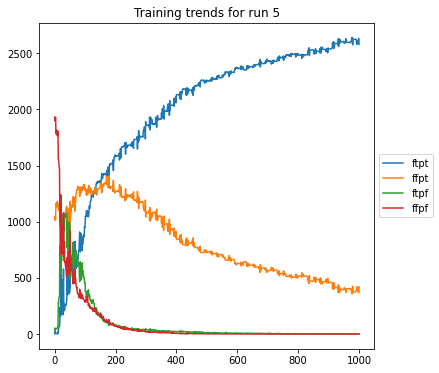

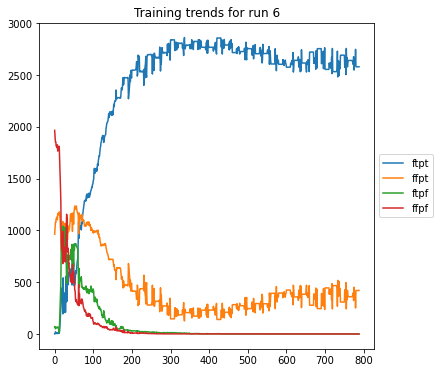

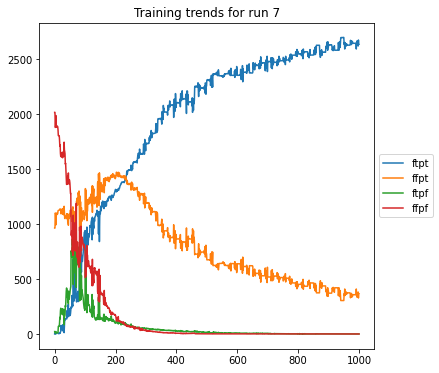

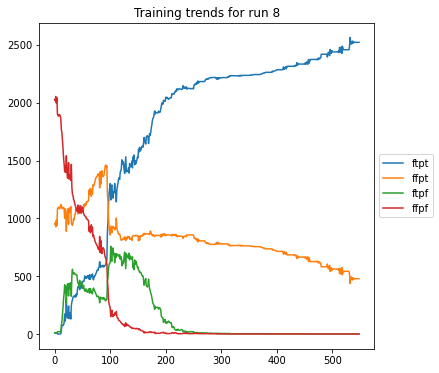

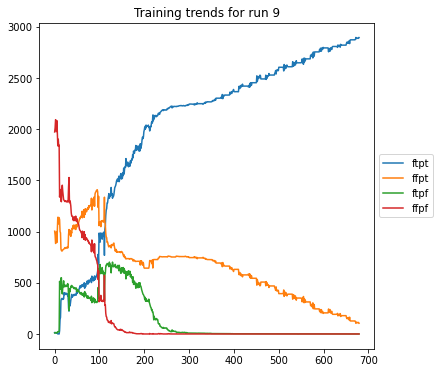

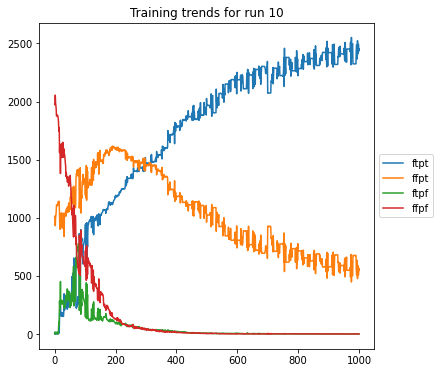

In [144]:
cnt=1
for epoch, analysis_data in full_analysis:
  analysis_data = np.array(analysis_data)
  # print("="*20+"run ",cnt,"="*20)
  
  plt.figure(figsize=(6,6))
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,0],label="ftpt")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,1],label="ffpt")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,2],label="ftpf")
  plt.plot(np.arange(0,epoch+2,1),analysis_data[:,3],label="ffpf")

  plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
  plt.title("Training trends for run "+str(cnt))
  plt.savefig(path+"what_where/every10/run"+str(cnt)+".png",bbox_inches="tight")
  plt.savefig(path+"what_where/every10/run"+str(cnt)+".pdf",bbox_inches="tight")
  cnt+=1


In [145]:
np.mean(np.array(FTPT_analysis),axis=0) #array([87.85333333,  5.92      ,  0.        ,  6.22666667])

array([88.86, 11.14,  0.  ,  0.  ])

In [146]:
FTPT_analysis.to_csv(path+"what_where/FTPT_analysis_every10.csv",index=False)

In [147]:
FTPT_analysis

,FTPT,FFPT,FTPF,FFPF
0,94.733333,5.266667,0.0,0.0
1,92.966667,7.033333,0.0,0.0
2,99.866667,0.133333,0.0,0.0
3,78.900000,21.100000,0.0,0.0
4,85.966667,14.033333,0.0,0.0
5,86.000000,14.000000,0.0,0.0
6,87.800000,12.200000,0.0,0.0
7,84.066667,15.933333,0.0,0.0
8,96.500000,3.500000,0.0,0.0
9,81.800000,18.200000,0.0,0.0
